In [1]:
# Version: 0.0.1
# Date:    2022-07-22
# Author:  P. J. Vetter, Timo Joas
# Email=  philipp.vetter@uni-ulm.de;

In [2]:
# Simulation to investigate the robustness of the optimal control pulse. 
# Pulse units are abstracted away by imported ArbPulse class

# The oc_element function reads in the pulse files and creates the corresponding pulse

# all possible initial states are defined in the 'Initial State' section
# density matrix of the m_s = 0 state: rho_ms0 
# density matrix of the m_s = -1 state: rho_msm1
# density matrix of the x state: rho_x
# density matrix of the y state: rho_y

# (The first run might take a bit longer due to the plot generation)

# Packages

In [1]:
import os
os.getcwd()

'C:\\Users\\Setup3-PC\\Desktop\\qudi\\user_scripts\\Timo\\own\\optimalcontrol'

In [2]:
#%matplotlib notebook
#%matplotlib notebook

import qutip
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import os
import copy as cp
from scipy import interpolate, linalg
import matplotlib as mpl

from oc_simlib import TimeDependentSimulation, SimParameters, ArbPulse, PredefinedArbPulses

plt.rcParams.update({'font.size': 30})  
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# Library

In [114]:
def demod_iq_simple(samples, f_carrier, t):
    # integrate the following equation over N periods and assume that f(I) << f
    # s= I*sin(ft) + Q*cos(ft) | *sin
        
    f = f_carrier
    t_per = 1/f
    n_per = int(np.round(t[-1] / t_per))
    idx_t_per = int(np.argmin(abs(t_per - t)))


    i, q = [], []
    for idx in range(0, n_per):
        i_start = idx*idx_t_per
        i_end = (idx+1)*idx_t_per
        s = samples[i_start:i_end]
        ts = 2*np.pi*f*t[i_start:i_end]

        i.append(np.trapz(s*np.sin(ts))/np.pi)
        q.append(np.trapz(s*np.cos(ts))/np.pi)
    
    return i,q

def get_f_limits(f_res, f_centers_block, df=10e6, symm_block=False):
    f_centers_block_mhz = 1e-6 * np.asarray(f_centers_block).flatten()
    f_res_mhz = f_res*1e-6
    df_mhz = df*1e-6
    freqs = []
    if symm_block:
        deltas = []
        for f_mhz in f_centers_block_mhz:
            deltas.append(abs(f_mhz - f_res_mhz))
        
        f_centers = []
        for d_mhz in deltas:
            f_center_2_mhz_min = f_res_mhz - d_mhz
            f_center_2_mhz_plus = f_res_mhz + d_mhz
            f_centers.append(f_center_2_mhz_min)
            f_centers.append(f_center_2_mhz_plus)
    else:
        f_centers = f_centers_block_mhz

    for f in f_centers:
        freqs.append([1e6*(f-df_mhz), 1e6*(f+df_mhz)])
    return freqs
    
def calc_crosstalk_penalty(freqs, spin_pop, f_res, f_center_block, df, symm_block=False, fac_penalty=1):

    
    idxs = np.empty((0), dtype=int)
    for (f_min, f_max) in get_f_limits(f_res, f_center_block, df, symm_block=symm_block):      
        idxs = np.append(idxs, np.where(np.logical_and(freqs >= f_min, freqs <= f_max)))
    
    #return idxs
    spin_pop = np.mean(spin_pop[idxs])
    
    # as in optimalcontrol_quocs.ipynb
    fom_sim = (1 + fac_penalty*(abs(1-spin_pop)))
    
    return fom_sim

def partial_trace(rho, sub=0, dims=None):
    if dims is None:
        dims = [[2,2],[2,2]]
    return np.asarray(qutip.Qobj(rho, dims=dims).ptrace(sub))    

def swap_basis_def(rho):
    # Genkos state definition is different!
    return np.rot90(rho,2).T

def sample_pulse_timegrid(pulse, f_carrier, sample_rate=None):
    timegrid_pulse = pulse.get_timegrid(unit='s')
    t_pulse = timegrid_pulse[-1]
    if sample_rate is None:
        dt_sample = 1/pulsedmeasurementlogic.pulsegenerator().get_sample_rate()
    else:
        dt_sample = 1/sample_rate
    timegrid_sampling = np.arange(0, t_pulse, dt_sample)
    
    return timegrid_sampling
    

def sample_pulse(pulse, f_carrier, sample_rate=None, phase_carrier_rad=0):
    timegrid_pulse = pulse.get_timegrid(unit='s')
    timegrid_sampling = sample_pulse_timegrid(pulse, f_carrier, sample_rate)
    amplitude = pulse.get_data_ampl(unit='V')
    phase = pulse.get_data_phase(unit='V')

    
    amplitude_func = interpolate.interp1d(timegrid_pulse, amplitude)
    phase_func = interpolate.interp1d(timegrid_pulse, phase)
    samples_arr = _get_sine_func(timegrid_sampling, amplitude_func, f_carrier, phase_carrier_rad, phase_func)
    
    return samples_arr


def _get_sine_func(time_array, amplitude_func, frequency, phase_rad, phase_func):
    samples_arr = amplitude_func(time_array - time_array[0]) * np.sin(2*np.pi * frequency * time_array + phase_rad) \
                  + phase_func(time_array - time_array[0]) * np.cos(2*np.pi * frequency * time_array + phase_rad)

    return samples_arr


def get_rescale_factor_ampl(pulse, f_carrier, max_ampl_v=0.25, sample_rate=None):
    # shaddows qudi::sampling_func
    
    # sampling for the awg has an unknown pulse position and hence phase
    # make sure that the pulse works for all phases by calculating rescale factor for worst case
    phases_rad = np.linspace(0, 2*np.pi, 100)
    samples_arr = sample_pulse(pulse, f_carrier, sample_rate=sample_rate)
    for ph in phases_rad:
        samples_curr = sample_pulse(pulse, f_carrier, phase_carrier_rad=ph, sample_rate=sample_rate)
        if np.max(samples_curr) > np.max(samples_arr):
            samples_arr = samples_curr
            #logger.debug(f"New max pulse ampl {np.max(samples_curr)} for phase {ph/np.pi} pi")
            
    max_sample_before = np.max(samples_arr)
    
    # avoid re-scaling by the pg, todo: think of better way
    import scipy
    if max(abs(samples_arr)) > 0.25:
        biggest_val = max([abs(np.min(samples_arr)), np.max(samples_arr)])
        mapper = scipy.interpolate.interp1d([-biggest_val, biggest_val], [-max_ampl_v, max_ampl_v])
        samples_arr = mapper(samples_arr)
        
    max_samples_after = np.max(samples_arr)
    
    return max_samples_after/max_sample_before
    
0

0

In [4]:
# shaddowed from Phlilip V.

def calc_chi(rho0_chi,rho1_chi,rho2_chi,rho3_chi):
    #"Quantum State Tomography: calculate matrix Chi from given density matrices rho1,..,rho4"
    sigx = np.array([[0,1],[1,0]])

    #Defintion of Matrix M

    M=np.zeros([8,8],dtype=complex)
    M[0,0]=0
    M[0,1]=0
    M[0,2]=0
    M[0,3]=0
    M[0,4]=0
    M[0,5]=0
    M[0,6]=1
    M[0,7]=0

    M[1,0]=0
    M[1,1]=0
    M[1,2]=0
    M[1,3]=0
    M[1,4]=0
    M[1,5]=0
    M[1,6]=0
    M[1,7]=1

    M[2,0]=1
    M[2,1]=0
    M[2,2]=0
    M[2,3]=0
    M[2,4]=0
    M[2,5]=0
    M[2,6]=0
    M[2,7]=0

    M[3,0]=0
    M[3,1]=1
    M[3,2]=0
    M[3,3]=0
    M[3,4]=0
    M[3,5]=0
    M[3,6]=0
    M[3,7]=0

    M[4,0]=0.5
    M[4,1]=0
    M[4,2]=-0.5j
    M[4,3]=0
    M[4,4]=0.5j
    M[4,5]=0
    M[4,6]=0.5
    M[4,7]=0

    M[5,0]=0
    M[5,1]=0.5
    M[5,2]=0
    M[5,3]=-0.5j
    M[5,4]=0
    M[5,5]=0.5j
    M[5,6]=0
    M[5,7]=0.5

    M[6,0]=0.5
    M[6,1]=0
    M[6,2]=-0.5
    M[6,3]=0
    M[6,4]=-0.5
    M[6,5]=0
    M[6,6]=0.5
    M[6,7]=0

    M[7,0]=0
    M[7,1]=0.5
    M[7,2]=0
    M[7,3]=-0.5
    M[7,4]=0
    M[7,5]=-0.5
    M[7,6]=0
    M[7,7]=0.5

    #calculate inverse of matrix M
    Minv = np.linalg.inv(M)
    
    #convert matrices rho1,...,rho4 to one 8x2 matrix
    rho_chi=np.zeros([8,2],dtype=complex)
    rho_chi[0,0]=rho0_chi[0,0]
    rho_chi[0,1]=rho0_chi[0,1]
    rho_chi[1,0]=rho0_chi[1,0]
    rho_chi[1,1]=rho0_chi[1,1]

    rho_chi[2,0]=rho1_chi[0,0]
    rho_chi[2,1]=rho1_chi[0,1]
    rho_chi[3,0]=rho1_chi[1,0]
    rho_chi[3,1]=rho1_chi[1,1]

    rho_chi[4,0]=rho2_chi[0,0]
    rho_chi[4,1]=rho2_chi[0,1]
    rho_chi[5,0]=rho2_chi[1,0]
    rho_chi[5,1]=rho2_chi[1,1]

    rho_chi[6,0]=rho3_chi[0,0]
    rho_chi[6,1]=rho3_chi[0,1]
    rho_chi[7,0]=rho3_chi[1,0]
    rho_chi[7,1]=rho3_chi[1,1]
    
    #Minv times rho
    rhoprime = np.matmul(Minv,rho_chi)
    #convert rhoprime (8x2) into a 4x4 matrix
    rhoM=np.zeros([4,4],dtype=complex)
    rhoM[0:2,0:2]=rhoprime[0:2,0:2]
    rhoM[0:2,2:4]=rhoprime[2:4,0:2]
    rhoM[2:4,0:2]=rhoprime[4:6,0:2]
    rhoM[2:4,2:4]=rhoprime[6:9,0:2]
    
    #Definition of Lambda
    Lambda=np.zeros([4,4],dtype=complex)
    Lambda[0:2,0:2]=np.identity(2)
    Lambda[2:4,0:2]=sigx
    Lambda[0:2,2:4]=sigx
    Lambda[2:4,2:4]=-np.identity(2)
    Lambda = Lambda * 0.5
    
    #calculate Chi
    chi = np.matmul(Lambda,np.matmul(rhoM,Lambda))                    
    
    return chi


# Variables

## Load pulses

In [184]:



folder = r"input_pulses\rect"
name = "rec_amp_20MHz_0.025mus_"
#pulse = ArbPulse.load_pulse(folder, name, unit_t='µs', unit_data='MHz')

folder = r"C:\Software\qudi_data\optimal_control_assets\_from_setup9\20220831_3_nv2_rabiMax=15MHz_guessFromReisser_110ns_pen=10"
folder = r"C:\Software\qudi_data\optimal_control_assets\_from_setup9\20220831_1_nv2_rabiMax=15MHz_guessFromReisser_110ns_SimOnly_pen=10"
folder = r"C:\Software\qudi_data\optimal_control_assets\20220909_2_procTomo_simOnly_20MHz_100ns_pen=100"
folder = r"C:\Software\qudi_data\optimal_control_assets\20220914_1_onEq_pen=100"
folder = r"C:\Software\qudi_data\optimal_control_assets\20220912_2_rescaledSimOnly_20220909_2"
folder = r"C:\Software\qudi_data\optimal_control_assets\_from_setup9\20220729_1_guessFromReisserMsc_penalty_fac=100"


folder = r"C:\Software\qudi_data\optimal_control_assets\20221005_expCrosstalk_from20220929_2"
#folder = r"C:\Software\qudi_data\optimal_control_assets\_from_setup9\20220729_1_guessFromReisserMsc_penalty_fac=100"

name = "opt_res_"
name = "on_nv=2_"
#pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*1/50*1e3,
#                            )
#pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*1/48.08*1e3,
#                            )
#pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/0.23*1/49.3*1e3,
#                            )
pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
                            func_ampl_v_2_omega_mhz=lambda x: x/0.18737*1/61.4*1e3,
                           )
    


#folder = r"C:\Software\qudi_data\optimal_control_assets\20220902_3_onEq_guessFromReisser_simOnly_intermediate_pen=10"
#name = "on_nv=2_"
#pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*(1e-6/78.2e-9),
#                            func_omega_mhz_2_ampl_v=lambda y: y/(1e-6/78.2e-9)*0.25
#                            )
#folder = r"C:\Software\qudi_data\optimal_control_assets\_from_setup9\20220729_1_guessFromReisserMsc_penalty_fac=100"
#name = "opt_res_"
#pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: 0.983*x/0.24*20,
#                            func_omega_mhz_2_ampl_v=lambda x: 1/(x/0.24*20))

#folder = r"C:\Software\qudi_data\optimal_control_assets\20220727_1_guessFromReisserMsc"
#name = "opt_res_"
#pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*20,
#                            func_omega_mhz_2_ampl_v=lambda x: 1/(x/0.25*20))

#folder = r"C:\Software\qudi_data\optimal_control_assets\20220826_1_procTomo_guessFromWeakRect_pen=10"
#name = "opt_res_"
#name = "opt_res_"
#pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*1/39.1*1e3,
#                            func_omega_mhz_2_ampl_v=lambda x: 1/(x/0.25*1/39.1*1e3))


#folder = r"C:\Software\qudi_data\optimal_control_assets\20220818_procTomo_fromWeak_1"
#fname = r"opt_res_"
#pulse = ArbPulse.load_pulse(folder, fname, unit_t='s', unit_data='V',
#                            func_ampl_v_2_omega_mhz=lambda x: x/0.25*25,
#                            func_omega_mhz_2_ampl_v=lambda x: 1/(x/0.25*25))

#folder = r"C:\Software\qudi_data\optimal_control_assets\Reisser_MSc_pulse_1"
#name = "Opt_Pulse_01_"
#pulse = ArbPulse.load_pulse(folder, name, unit_t='ns', unit_data='MHz')


# loading experimental pulse
# 0.25 = 20 MHz
#pulse = ArbPulse.load_pulse(folder, name, unit_t='s',  func_ampl_v_2_omega_mhz=lambda x: x/0.25*20)


#pulse = TimeDependentSimulation.load_pulse(folder, name, func_t_2_us=lambda t: t*1e6)
#
pulse.name




'20221005_expCrosstalk_from20220929_2/on_nv=2_'

In [79]:
1/39.1*1e3

25.57544757033248

In [80]:
len(pulse.as_dict()['timegrid_ampl'])

1000

In [81]:
import copy as cp
pulse2 = cp.copy(pulse)

pulse2

In [82]:
pulse3 = ArbPulse.shift_phase(pulse2, np.pi/2)
pulse3 = ArbPulse.concatenate(pulse, pulse3)

pulse3

## Jülich (Ferlemann) pulse to here

Pulse files contain pulses for NV1 and NV2. Adding them toghether gives a good kron(pix, pix)

In [243]:
# shaddows optimcalcontrol_quocs.ipynb
import datetime
import types
import inspect

def get_pulse_filename(path, name="", name_ampl="amplitude.txt", name_phase="phase.txt"):
    return os.path.abspath(path + "/" + name + name_ampl), os.path.abspath(path + "/" + name + name_phase)

def dict_2_header_str(in_dict):
    out_str = ""
    for key, val in in_dict.items():
        out_str += f"{key}: {val}\n"
        
    return out_str


def lambda_2_str(func):
    if type(func) is types.FunctionType:
        try:
            funcString = inspect.getsourcelines(func)[0][0]
            funcString.strip("['\n']").split("=")[1]
            return funcString
        except IndexError:
            return str(func) + '_LAMBDA_CONV_FAIL'
    else:
        raise ValueError("")

def save_pulse(path, data_ampl, data_phase, name="", header_dict=None, 
               name_ampl="amplitude.txt", name_phase="phase.txt"):
    if header_dict is None:
        header_dict = {}
    
    def _lambda_2_str(dict_in):
        dict_out = cp.deepcopy(dict_in)
        for key, val in dict_in.items():
            if type(val) is types.FunctionType:
                funcString = lambda_2_str(val)
                dict_out[key] = funcString
        
        return dict_out
    
    try:
        header_dict = _lambda_2_str(header_dict)
        now = datetime.datetime.now() # current date and time
        header_dict['timestamp'] = now.strftime("%Y/%m/%d-%H:%M:%S")
        
        
        fname_ampl, fname_phase = get_pulse_filename(path, name=name, name_ampl=name_ampl, name_phase=name_phase)
        
        if data_ampl is not None:
            try:
                os.remove(fname_ampl)
            except IOError:
                pass
            np.savetxt(fname_ampl,  data_ampl,  header=dict_2_header_str(header_dict))
        if data_phase is not None:
            try:
                os.remove(fname_phase)
            except IOError:
                pass
            np.savetxt(fname_phase, data_phase, header=dict_2_header_str(header_dict))
    except:
        logger.exception("")
   
def pulse_save(path, pulse, name="opt_res_", name_ampl="amplitude.txt", name_phase="phase.txt", header_dict=None):

    t_amplitude = pulse.get_timegrid(unit='s')
    t_phase = pulse.get_timegrid(unit='s')
    amplitude = pulse.get_data_ampl(unit='V')
    phase = pulse.get_data_phase(unit='V')

    data_ampl = np.column_stack((t_amplitude, amplitude))
    data_phase = np.column_stack((t_phase, phase))

    save_pulse(path, data_ampl, data_phase, name=name, name_ampl=name_ampl, name_phase=name_phase, header_dict=header_dict)



#save_pulse(folder, pulse._data_ampl, pulse._data_phase)


In [247]:
folder = r"C:\Software\qudi_data\optimal_control_assets\_fromJülich\20220928_1_X1X2_pulse_simultaneous"
fname = "pi_x12.npz"

raw = np.load(folder + "\\" + fname)

for nv_idx in [1,2]:

    pulse = ArbPulse()
    pulse.name = fname

    pulse.timegrid_unit = 'us'
    pulse.data_unit = 'V'
    
    if nv_idx == 1:
        pulse._data_ampl = 0.01*raw['pulse1']
        pulse._data_phase = 0.01*raw['pulse2']
        pulse._timegrid_ampl = raw['time_grid1']
        pulse._timegrid_phase = raw['time_grid2']
    elif nv_idx == 2:
        pulse._data_ampl = 0.01*raw['pulse3']
        pulse._data_phase = 0.01*raw['pulse4']
        pulse._timegrid_ampl = raw['time_grid3']
        pulse._timegrid_phase = raw['time_grid4']
        

    pulse._func_ampl_v_2_omega_mhz=lambda x: x/1*80

    
    pulse_save(folder, pulse, name=f'jul_res_on_nv={nv_idx}_', header_dict={'func_ampl_v_2_omega_mhz': pulse._func_ampl_v_2_omega_mhz})

In [245]:
raw.keys()

['pulse1',
 'time_grid1',
 'pulse2',
 'time_grid2',
 'pulse3',
 'time_grid3',
 'pulse4',
 'time_grid4']

## Generate pulses

In [422]:


def generate_sine(freq_delta, omega, phase=0, n_t=1000):
        """
        
        """

        omega_mhz = omega * 1e-6
        freq_delta_mhz = freq_delta * 1e-6

        get_t_pix = PredefinedArbPulses.get_t_pix
        get_iq = PredefinedArbPulses.get_iq

        tpi_us = get_t_pix(omega_mhz, pix=1)
        t_pulse = tpi_us
        #t_pulse = 1e6 * t_pulse

        # rabi in MHz, times in us
        timegrid_us = np.linspace(0, t_pulse, n_t)
        data_ampl = np.zeros((len(timegrid_us)))  # I quadrature
        data_phase = np.zeros((len(timegrid_us)))  # Q

        phases = [0 + phase]
        tpulse_by_pi = [1]
        # pad with zero amplitude/phase
        if t_pulse != tpi_us:
            phases.append(0)
            tpulse_by_pi.append(0)
        # phases = [np.pi/2]
        # tpulse_by_pi = [0.5]

        t_curr_us, t_end_us = 0, 0
        for i_comppulse, phi in enumerate(phases):
            pix = tpulse_by_pi[i_comppulse]
            if pix != 0:
                t_end_us = t_curr_us + get_t_pix(omega_mhz, pix=pix)
            else:  # zero pad until end
                t_end_us = timegrid_us[-1]
                val_iq = np.asarray([0, 0])

            idx_start = np.argmin(np.abs(timegrid_us - t_curr_us))
            idx_end = np.argmin(np.abs(timegrid_us - t_end_us))
            
            t = np.linspace(t_curr_us, t_end_us, idx_end-idx_start+1)
            rabi_eff_mhz = np.sqrt(freq_delta_mhz**2 + omega_mhz**2)
            val_i = (0.5*omega_mhz*np.sin(2*np.pi*freq_delta_mhz*t)+ omega_mhz)#rabi_eff_mhz
            val_q = -0*np.sin(2*np.pi*freq_delta_mhz*t)*2# + omega_mhz
            
            data_ampl[idx_start:idx_end + 1] = val_i
            data_phase[idx_start:idx_end + 1] = val_q

            if t_curr_us == timegrid_us[-1]:
                break
            t_curr_us = t_end_us

        idx_end = np.argmin(np.abs(timegrid_us - t_end_us))

        assert idx_end == n_t - 1

        pulse = ArbPulse()
        pulse.name = 'sine_phi={phase/np.pi:.1f}pi'

        pulse.timegrid_unit = 'us'
        pulse.data_unit = 'MHz'

        pulse._data_ampl = data_ampl
        pulse._data_phase = data_phase
        pulse._timegrid_ampl = timegrid_us
        pulse._timegrid_phase = timegrid_us

        return pulse

pulse = generate_sine(2.1e6, 0.5e6)
pulse.as_dict()

{'name': 'sine_phi={phase/np.pi:.1f}pi',
 'folder': None,
 'file': [],
 'timegrid_unit': 'us',
 'data_unit': 'MHz',
 'data_ampl': array([0.5  , 0.503, 0.507, 0.51 , 0.513, 0.516, 0.52 , 0.523, 0.526,
        0.53 , 0.533, 0.536, 0.539, 0.543, 0.546, 0.549, 0.552, 0.556,
        0.559, 0.562, 0.565, 0.568, 0.572, 0.575, 0.578, 0.581, 0.584,
        0.587, 0.59 , 0.593, 0.596, 0.6  , 0.603, 0.606, 0.609, 0.611,
        0.614, 0.617, 0.62 , 0.623, 0.626, 0.629, 0.632, 0.634, 0.637,
        0.64 , 0.643, 0.645, 0.648, 0.651, 0.653, 0.656, 0.659, 0.661,
        0.664, 0.666, 0.669, 0.671, 0.673, 0.676, 0.678, 0.68 , 0.683,
        0.685, 0.687, 0.689, 0.691, 0.693, 0.696, 0.698, 0.7  , 0.702,
        0.703, 0.705, 0.707, 0.709, 0.711, 0.713, 0.714, 0.716, 0.718,
        0.719, 0.721, 0.722, 0.724, 0.725, 0.727, 0.728, 0.729, 0.731,
        0.732, 0.733, 0.734, 0.735, 0.737, 0.738, 0.739, 0.74 , 0.741,
        0.741, 0.742, 0.743, 0.744, 0.744, 0.745, 0.746, 0.746, 0.747,
        0.747, 0.74

In [181]:



#pulse = PredefinedArbPulses.generate_levitt(1/39.1e-9, phase=0, t_pulse=100e-9)
#pulse = generate_levitt(1/39.1e-9, phase=0, t_pulse=100e-9)
#pulse = PredefinedArbPulses.generate_rect_pi(20e6, phase=np.pi/2)
pulse = PredefinedArbPulses.generate_rect_pi(8e6, phase=0)

# rect pulse that has 2nd sinc minimum at df
#df = 96e6
#n_comp = 3
#rabi_comp = 96e6/2/n_comp
#pulse = PredefinedArbPulses.generate_rect_pi(rabi_comp, phase=0)


# zero pulse
#pulse._data_ampl[:] = 0
#pulse['data_phase']
#val_i, val_q = np.asarray([1,0])*1
#np.asarray([np.pi/2, 0, np.pi/2]) + 0

#data_ampl = np.asarray([0,0,0])
#data_ampl[0:3] = 1

#pulse.as_dict()
#rabi_comp*1e-6

## Plot pulses

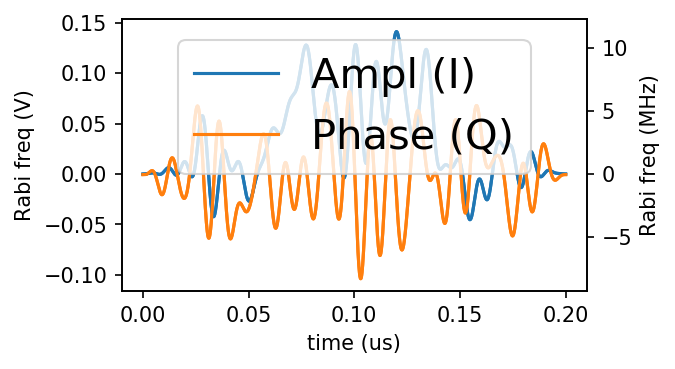

(0.1410716920381685, 11.28573536305348)

In [248]:
import matplotlib.pyplot as plt
    
t_amplitude = pulse.get_timegrid(unit='us')
t_phase = pulse.get_timegrid(unit='us')
try:
    amplitude = pulse.get_data_ampl(unit='V')
    phase = pulse.get_data_phase(unit='V')
    max_ampl = np.max([np.max(phase), np.max(amplitude)])
except ValueError:
    amplitude, phase, max_ampl = None, None, None
    
try:
    amplitude_rabi = pulse.get_data_ampl(unit='MHz')
    phase_rabi = pulse.get_data_phase(unit='MHz')
    max_rabi = np.max([np.max(amplitude_rabi), np.max(phase_rabi)])
except ValueError:
    amplitude_rabi, phase_rabi, max_rabi = None, None, None



try:
    #plt.figure(figsize=(10,6))
    fig, ax1 = plt.subplots()
    if amplitude is not None:
        ax1.plot(t_amplitude, amplitude, label="Ampl (I)")
        ax1.plot(t_phase, phase, label="Phase (Q)")
        ax1.set_ylabel("Rabi freq (V)")
        ax1.set_xlabel("time (us)")
    else:
        ax1.get_yaxis().set_visible(False)
        
    ax2 = ax1.twinx()
    if amplitude_rabi is not None:
        ax2.plot(t_amplitude, amplitude_rabi, label="Ampl (I)")
        ax2.plot(t_phase, phase_rabi, label="Phase (Q)")
        ax2.set_ylabel("Rabi freq (MHz)")
    else:
        ax2.get_yaxis().set_visible(False)
    
    # plt.plot(t_phase, phase+amplitude, label="I+Q")
    plt.legend(loc='best', prop={'size': 20})
    plt.show()
except:
    logger.exception("")
    
    
max_ampl, max_rabi

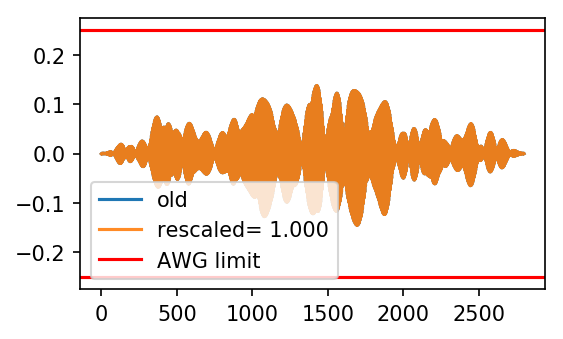

(0.1373606291978512, 1.0)

In [249]:
ampl_max = 0.25
f_sample= 14e9

max_old = np.max(sample_pulse(pulse, f_res, sample_rate=f_sample))

fac = get_rescale_factor_ampl(pulse, f_res, max_ampl_v=ampl_max, sample_rate=f_sample)
samples = sample_pulse(pulse, f_res, sample_rate=f_sample)

pulse_new = cp.deepcopy(pulse)
pulse_new._data_ampl  = fac*pulse_new._data_ampl
pulse_new._data_phase = fac*pulse_new._data_phase
samples_new = sample_pulse(pulse_new, f_res,  sample_rate=f_sample)


max_new = np.max(sample_pulse(pulse_new, f_res, sample_rate=f_sample))


plt.plot(samples, label="old")
plt.plot(samples_new, label=f"rescaled= {fac:.3f}", alpha=0.9)
plt.axhline(ampl_max, color='red', label='AWG limit')
plt.axhline(-ampl_max, color='red')

plt.legend()
plt.show()

np.max(samples), fac

## Transform waveform, demodulate to IQ

As check: take the sampeled, non-transformed pulse and bring back to IQ domain.

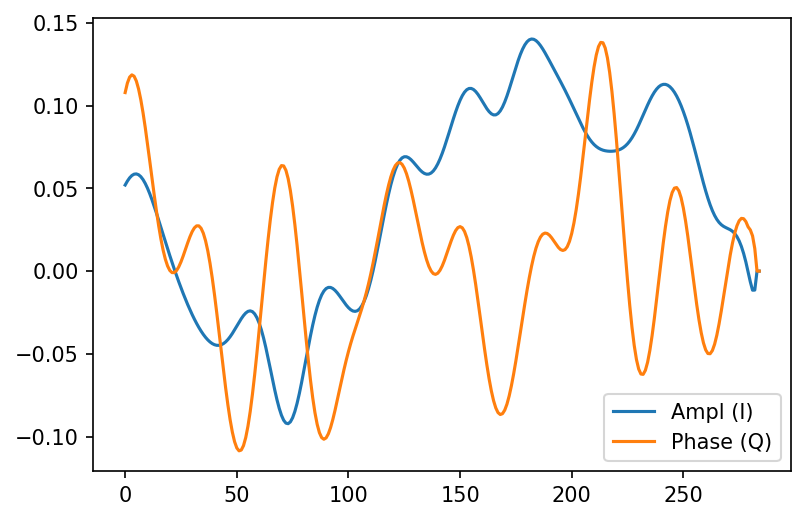

In [115]:

    
i, q = demod_iq_simple(samples, f_res, sample_pulse_timegrid(pulse, f_res, f_sample))
#plt.plot(pulse.get_timegrid(unit='s'), i)
plt.plot(i, label="Ampl (I)")
plt.plot(q, label="Phase (Q)")
plt.legend()

plt.show()


Transform pulse with transfer funtion, here: simple amplitude scaling

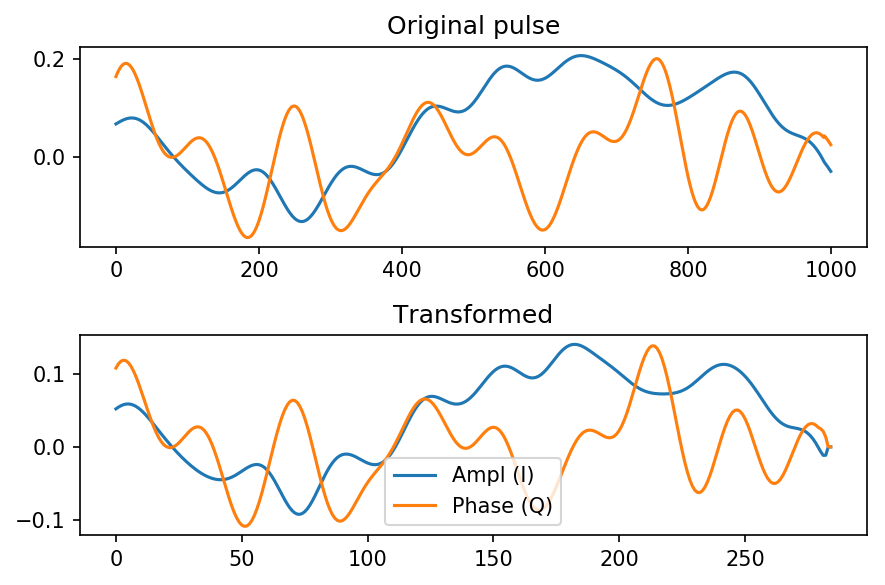

In [128]:
fac = 0.5

pulse_new = cp.deepcopy(pulse)
pulse_new._data_ampl  = fac*pulse_new._data_ampl
pulse_new._data_phase = fac*pulse_new._data_phase
samples_new = sample_pulse(pulse_new, f_res,  sample_rate=f_sample)

plt.figure()

plt.subplot(211)

#plt.plot(pulse.get_timegrid(unit='s'), i)
plt.plot(pulse._data_ampl, label="Ampl (I)")
plt.plot(pulse._data_phase, label="Phase (Q)")
ax = plt.gca()
ax.set_title("Original pulse")

plt.subplot(212)
i, q = demod_iq_simple(samples, f_res, sample_pulse_timegrid(pulse, f_res, f_sample))
#plt.plot(pulse.get_timegrid(unit='s'), i)
plt.plot(i, label="Ampl (I)")
plt.plot(q, label="Phase (Q)")

ax = plt.gca()
ax.set_title("Transformed")
plt.legend()

plt.tight_layout()
plt.show()


# Parameters, Operators

In [7]:

simp = SimParameters()
simp.dims = simp.S_x.dims   # temp, can delete

B = 90


# Measurements

Single simulation without error

In [13]:
rho = run_sim(None, pulse, B, simp)
sig_z = np.trace(np.matmul(rho, simp.P_nv))

rho_nv = partial_trace(rho, sub=0, dims=simp.dims)
rho
rho_nv

array([[ 0.003+0.j   , -0.003+0.034j],
       [-0.003-0.034j,  0.997+0.j   ]])

Init and read in X,Y

In [649]:
import scipy

u_init = 2*simp.S_x    # pi_X, 0->1, pulse on NV, 1 on 14-N
#u_init = scipy.linalg.sqrtm(2*simp.S_y)     # pi2_Y, 0->X, pulse on NV, 1 on 14-N
u_init = scipy.linalg.sqrtm(2*simp.S_x)      # pi2_Y, 0->-Y, pulse on NV, 1 on 14-N
u_init = None       # init = 0

#vec_init = simp.

rho = run_sim(None, pulse, B, simp, nv_init_ux=u_init, nv_read_ux=u_init)
rho_nv = partial_trace(rho, sub=0, dims=simp.dims)

rho_nv
#u_init

array([[0.047+0.j, 0.191+0.j],
       [0.191-0.j, 0.953+0.j]])

In [465]:
delta_f = -1500e6

us_init = [None, 2*simp.S_x, scipy.linalg.sqrtm(2*simp.S_x) , scipy.linalg.sqrtm(2*simp.S_y)]
rhos = []
rhos_init = []

for u_x in us_init:
    rho = run_sim(None, pulse, B, simp, delta_f=delta_f, nv_init_ux=u_x, nv_read_ux=None)
    rho_nv = partial_trace(rho, sub=0, dims=simp.dims)
    rho_nv = swap_basis_def(rho_nv)  # basis definition in Philip V. code is different
    rhos.append(rho_nv)
    
    rho_init = get_rho_init(u_x, simp)
    rho_init = partial_trace(rho_init, sub=0, dims=simp.dims)
    rho_init = swap_basis_def(rho_init)  # basis definition in Philip V. code is different
    rhos_init.append(rho_init)

    
rhos_init[2], rhos[2]

(array([[ 0.5+0.j , -0. +0.5j],
        [-0. -0.5j,  0.5+0.j ]]), array([[0.504+0.j  , 0.329-0.34j],
        [0.329+0.34j, 0.496+0.j  ]]))

## Simulated process tomography

In [223]:
def get_rho_init(nv_init_ux=None, sim_params=None):
    
    
    init_state = sim_params.rho_ms0
    if nv_init_ux is not None:
        u = np.asarray(nv_init_ux)
        init_state = np.matmul(np.matmul(u,init_state),u.conj().T)
        init_state = qutip.Qobj(init_state, dims=sim_params.dims)
    return init_state
    

def run_sim(self, pulse, B_gauss, sim_params, delta_f=0e6, nv_init_ux=None, nv_read_ux=None,
                  n_timebins=500, t_idle_extension=-1e-9):

    # for compability reason, accept pulse as dict or ArbPulse object
    # if supplying a dict, you are responsible for correct units!
    if type(pulse) == ArbPulse:
        pulse.set_unit_time('µs')
        pulse.set_unit_data('MHz')
        pulse = pulse.as_dict()

    B = B_gauss
    simp = sim_params
    oc_length = pulse['timegrid_ampl'][-1] + t_idle_extension*1e6
    delta_f_mhz = delta_f*1e-6
    
    t = np.linspace(0, oc_length, n_timebins)
    options=qutip.Options(atol=1e-15, rtol=1e-15, nsteps=1e8, store_final_state=True)

    init_state = get_rho_init(nv_init_ux, simp)
    
    freq = simp.D - simp.gamma_nv * B 
    
    # perform the measurement
    oc_el = TimeDependentSimulation.oc_element(t, pulse['timegrid_ampl'], pulse['data_ampl'], pulse['data_phase'],
                                               freq+delta_f_mhz, B, 1, simp)
    results_measurement = qutip.mesolve(oc_el, init_state, t, [], [simp.P_nv],
                                            options=options, progress_bar=None)
    
    rho_final = results_measurement.final_state
    if nv_read_ux is not None:
        u = np.asarray(nv_read_ux)
        rho_final = np.matmul(np.matmul(u,rho_final),u.conj().T)
        rho_final = qutip.Qobj(rho_final, dims=sim_params.dims)
    
    return rho_final


def sim_process_tomo(pulse, B, delta_f=0e6):
    
    rhos = []
    # convention in calc_chi: [1, pix, pi2x, pi2y]
    us_init = [None, 2*simp.S_x, scipy.linalg.sqrtm(2*simp.S_x) , scipy.linalg.sqrtm(2*simp.S_y)]

    for u_x in us_init:
        rho = run_sim(None, pulse, B, simp, delta_f=delta_f, nv_init_ux=u_x, nv_read_ux=None)
        rho_nv = partial_trace(rho, sub=0, dims=simp.dims)
        rho_nv = swap_basis_def(rho_nv)  # basis definition in Philip V. code is different

        rhos.append(rho_nv)

    chi_tomo = calc_chi(rhos[0], rhos[1], rhos[2], rhos[3])
    chi_tomo = swap_basis_def(chi_tomo)
    
    return chi_tomo

def sim_process_tomo_avg_hfs(pulse, B, delta_hfs=2.1e6):
    res_chi = []
    for delta in [0,-delta_hfs,+delta_hfs]:
        res_chi.append(sim_process_tomo(pulse, B, delta_f=delta))
    
    return (res_chi[0] + res_chi[1] + res_chi[2])/3
    

def fidelity_chi_pi_x(chi):
    #"calculate fidelity of Sx pi-pulse"
    #Definition of pauli and spin matrices
    sigx = np.array([[0,1],[1,0]])
    sigy = np.array([[0,-1j],[1j,0]])
    sigz = np.array([[1,0],[0,-1]])

    Sx = 0.5 * sigx
    Sy = 0.5 * sigy
    Sz= 0.5 * sigz

    #initial state
    init1 = np.array([[0,0],[0,1]])
    init2 = np.array([[1,0],[0,0]])
    init3 = np.matmul(np.matmul(linalg.expm(-1j*np.pi/2*Sx),init1),linalg.expm(1j*np.pi/2*Sx))
    init4 = np.matmul(np.matmul(linalg.expm(-1j*np.pi/2*Sy),init1),linalg.expm(1j*np.pi/2*Sy))

    #time evolution operator
    U = linalg.expm(-1j * np.pi * Sx)

    #final state
    final1 = np.matmul(np.matmul(U,init1),U.conj().transpose())
    final2 = np.matmul(np.matmul(U,init2),U.conj().transpose())
    final3 = np.matmul(np.matmul(U,init3),U.conj().transpose())
    final4 = np.matmul(np.matmul(U,init4),U.conj().transpose())
    
    #calculate theoretical chi of Sx pi-pulse
    chi_theo = calc_chi(final1,final2,final3,final4)
    
    # calculate figure of merit = gate fidelity
    #fom = np.real(np.trace(np.matmul(chi_theo.conj().transpose(),chi)))
    fom = 1 - 1/4 * np.trace(np.sqrt(np.matmul((chi-chi_theo).conj().transpose(),(chi - chi_theo))))
    
    return fom

0

0

If needed: swap pulse phase from X<->Y

In [23]:


d_i, d_q = cp.copy(pulse._data_ampl), cp.copy(pulse._data_phase)
pulse._data_ampl = d_q
pulse._data_phase = d_i

In [170]:

d_i, d_q = cp.copy(pulse._data_ampl), cp.copy(pulse._data_phase)
pulse._data_ampl = d_i
pulse._data_phase = d_q

On resonance

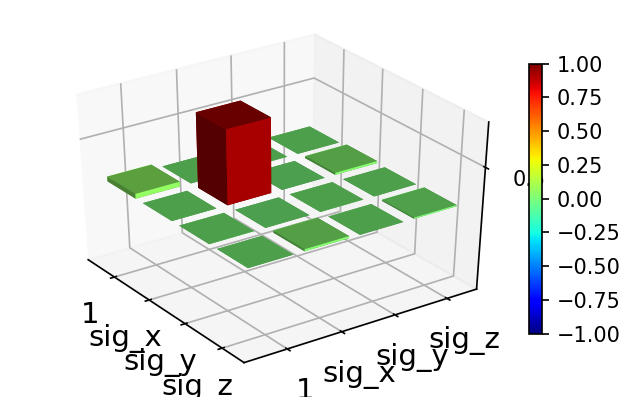

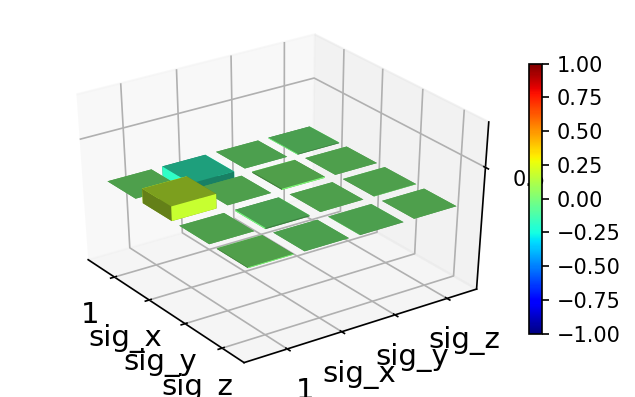

(array([[ 0.06 +0.j   ,  0.   -0.181j,  0.002-0.j   ,  0.   -0.01j ],
        [ 0.   +0.181j,  0.924+0.j   , -0.   +0.014j,  0.025+0.j   ],
        [ 0.002+0.j   , -0.   -0.014j,  0.001+0.j   ,  0.   +0.003j],
        [ 0.   +0.01j ,  0.025-0.j   ,  0.   -0.003j,  0.015+0.j   ]]),
 0.10874976623231014)

In [224]:
plt.rcParams['figure.figsize'] = [4, 3/5*4]
plt.rcParams['figure.dpi'] = 150

chi_tomo = sim_process_tomo(pulse, B, delta_f=0e6)

qutip.matrix_histogram(np.real(chi_tomo), limits=[-1,1],
                       xlabels=["1", "sig_x", "sig_y", "sig_z"], 
                       ylabels=["1", "sig_x", "sig_y", "sig_z"])


plt.show()
qutip.matrix_histogram(np.imag(chi_tomo), limits=[-1,1],
                       xlabels=["1", "sig_x", "sig_y", "sig_z"], 
                       ylabels=["1", "sig_x", "sig_y", "sig_z"])


plt.show()

fom = np.real(1 - fidelity_chi_pi_x(chi_tomo))
chi_tomo, fom

On Hyperfine lines

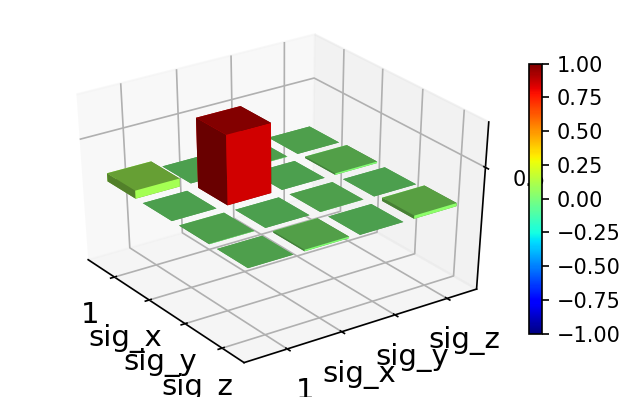

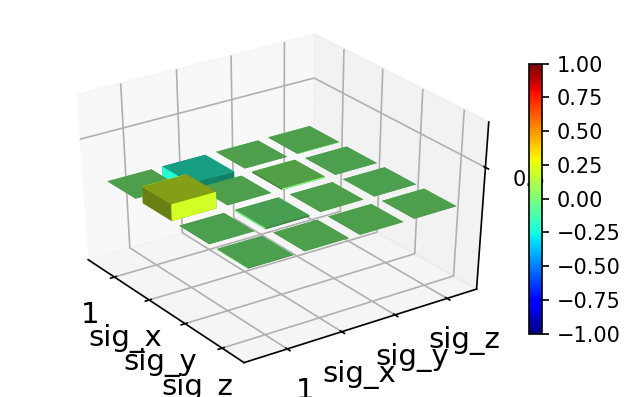

(array([[ 0.101+0.j   , -0.   -0.207j,  0.004+0.j   ,  0.   +0.006j],
        [-0.   +0.207j,  0.859+0.j   , -0.   +0.016j,  0.019-0.j   ],
        [ 0.004-0.j   , -0.   -0.016j,  0.001+0.j   , -0.   -0.001j],
        [ 0.   -0.006j,  0.019+0.j   , -0.   +0.001j,  0.04 +0.j   ]]),
 0.13575910032637872)

In [225]:
chi_mean = sim_process_tomo_avg_hfs(pulse, B, delta_hfs=2.1e6)

qutip.matrix_histogram(np.real(chi_mean), limits=[-1,1],
                       xlabels=["1", "sig_x", "sig_y", "sig_z"], 
                       ylabels=["1", "sig_x", "sig_y", "sig_z"])
plt.show()
qutip.matrix_histogram(np.imag(chi_mean), limits=[-1,1],
                       xlabels=["1", "sig_x", "sig_y", "sig_z"], 
                       ylabels=["1", "sig_x", "sig_y", "sig_z"])
plt.show()

fom = np.real(1 - fidelity_chi_pi_x(chi_mean))
chi_mean, fom

At detuning (should =1)

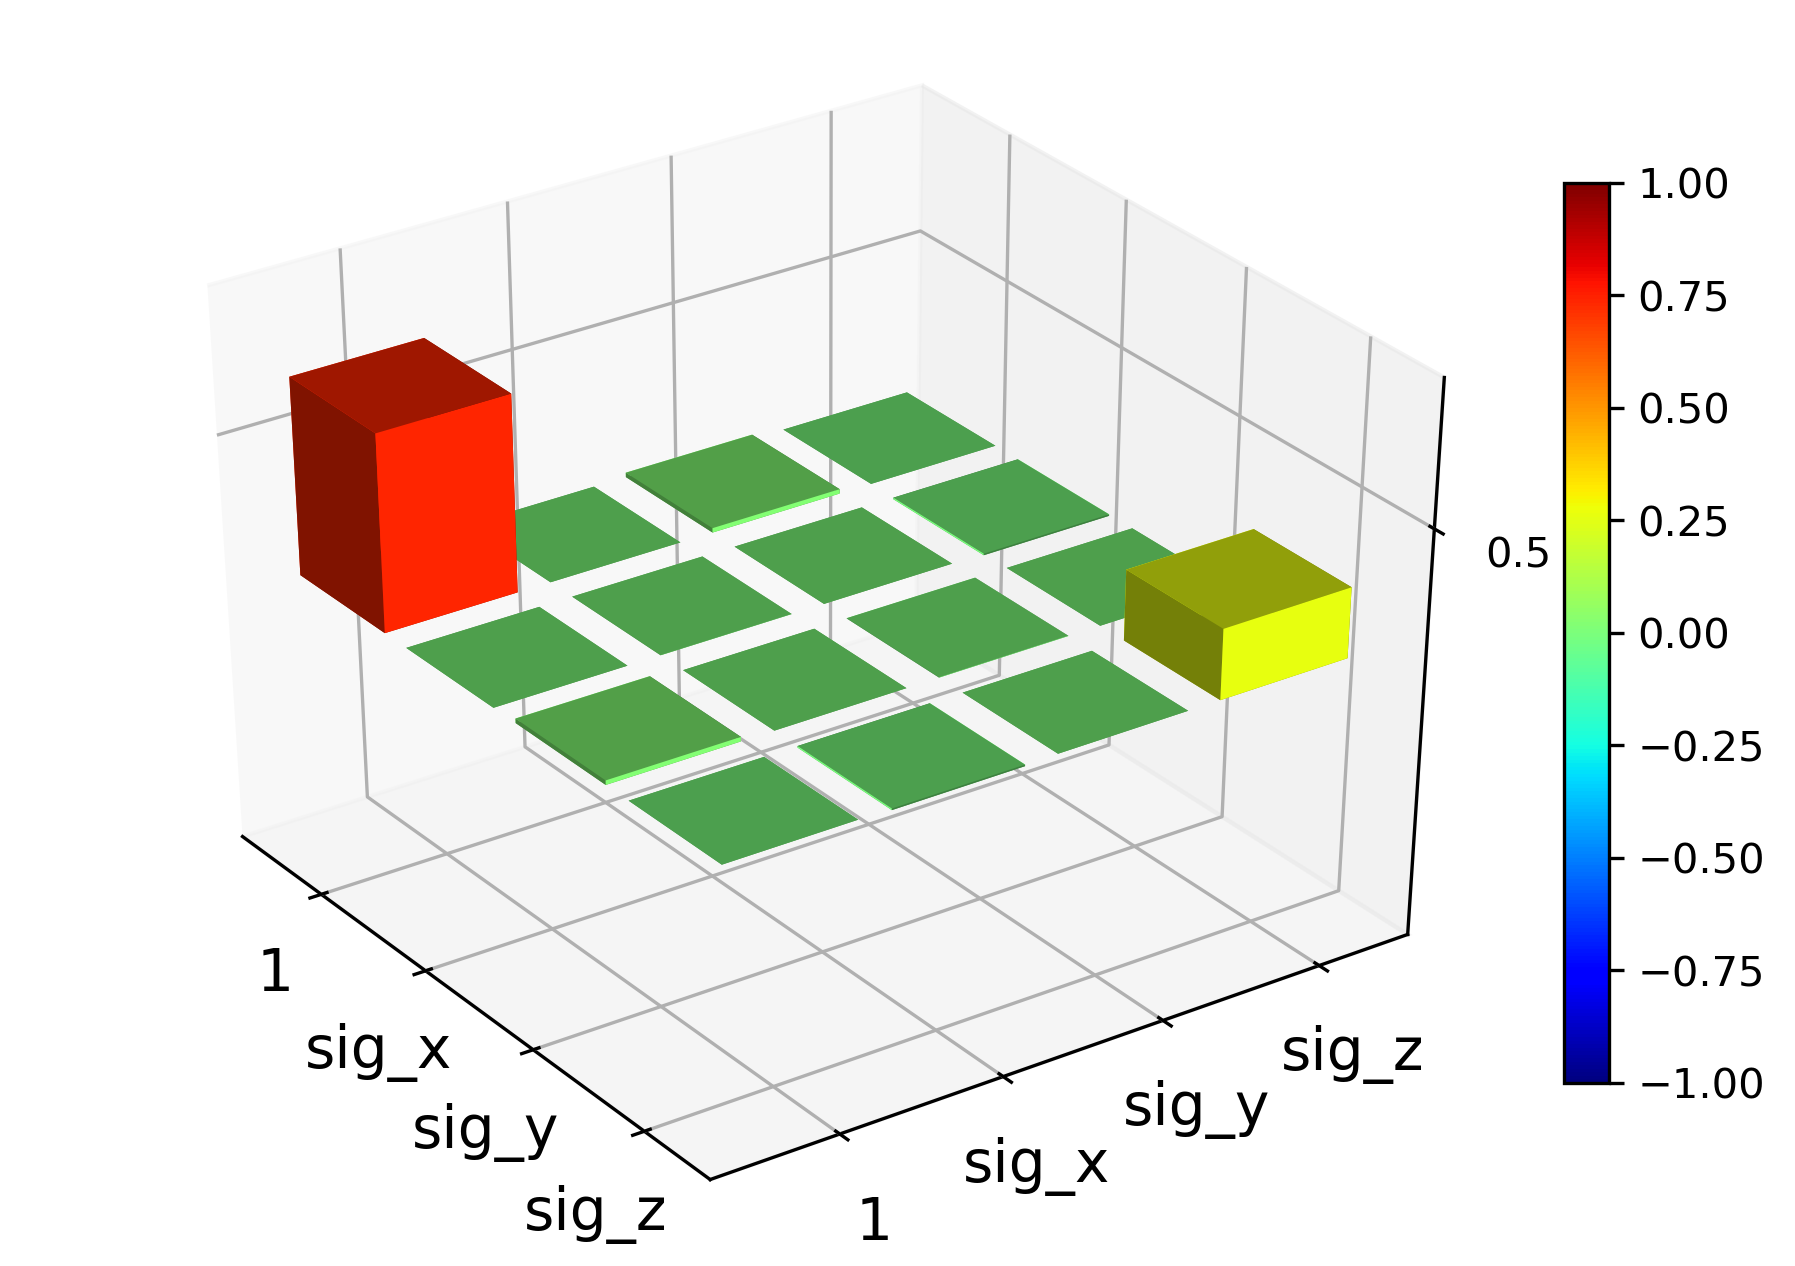

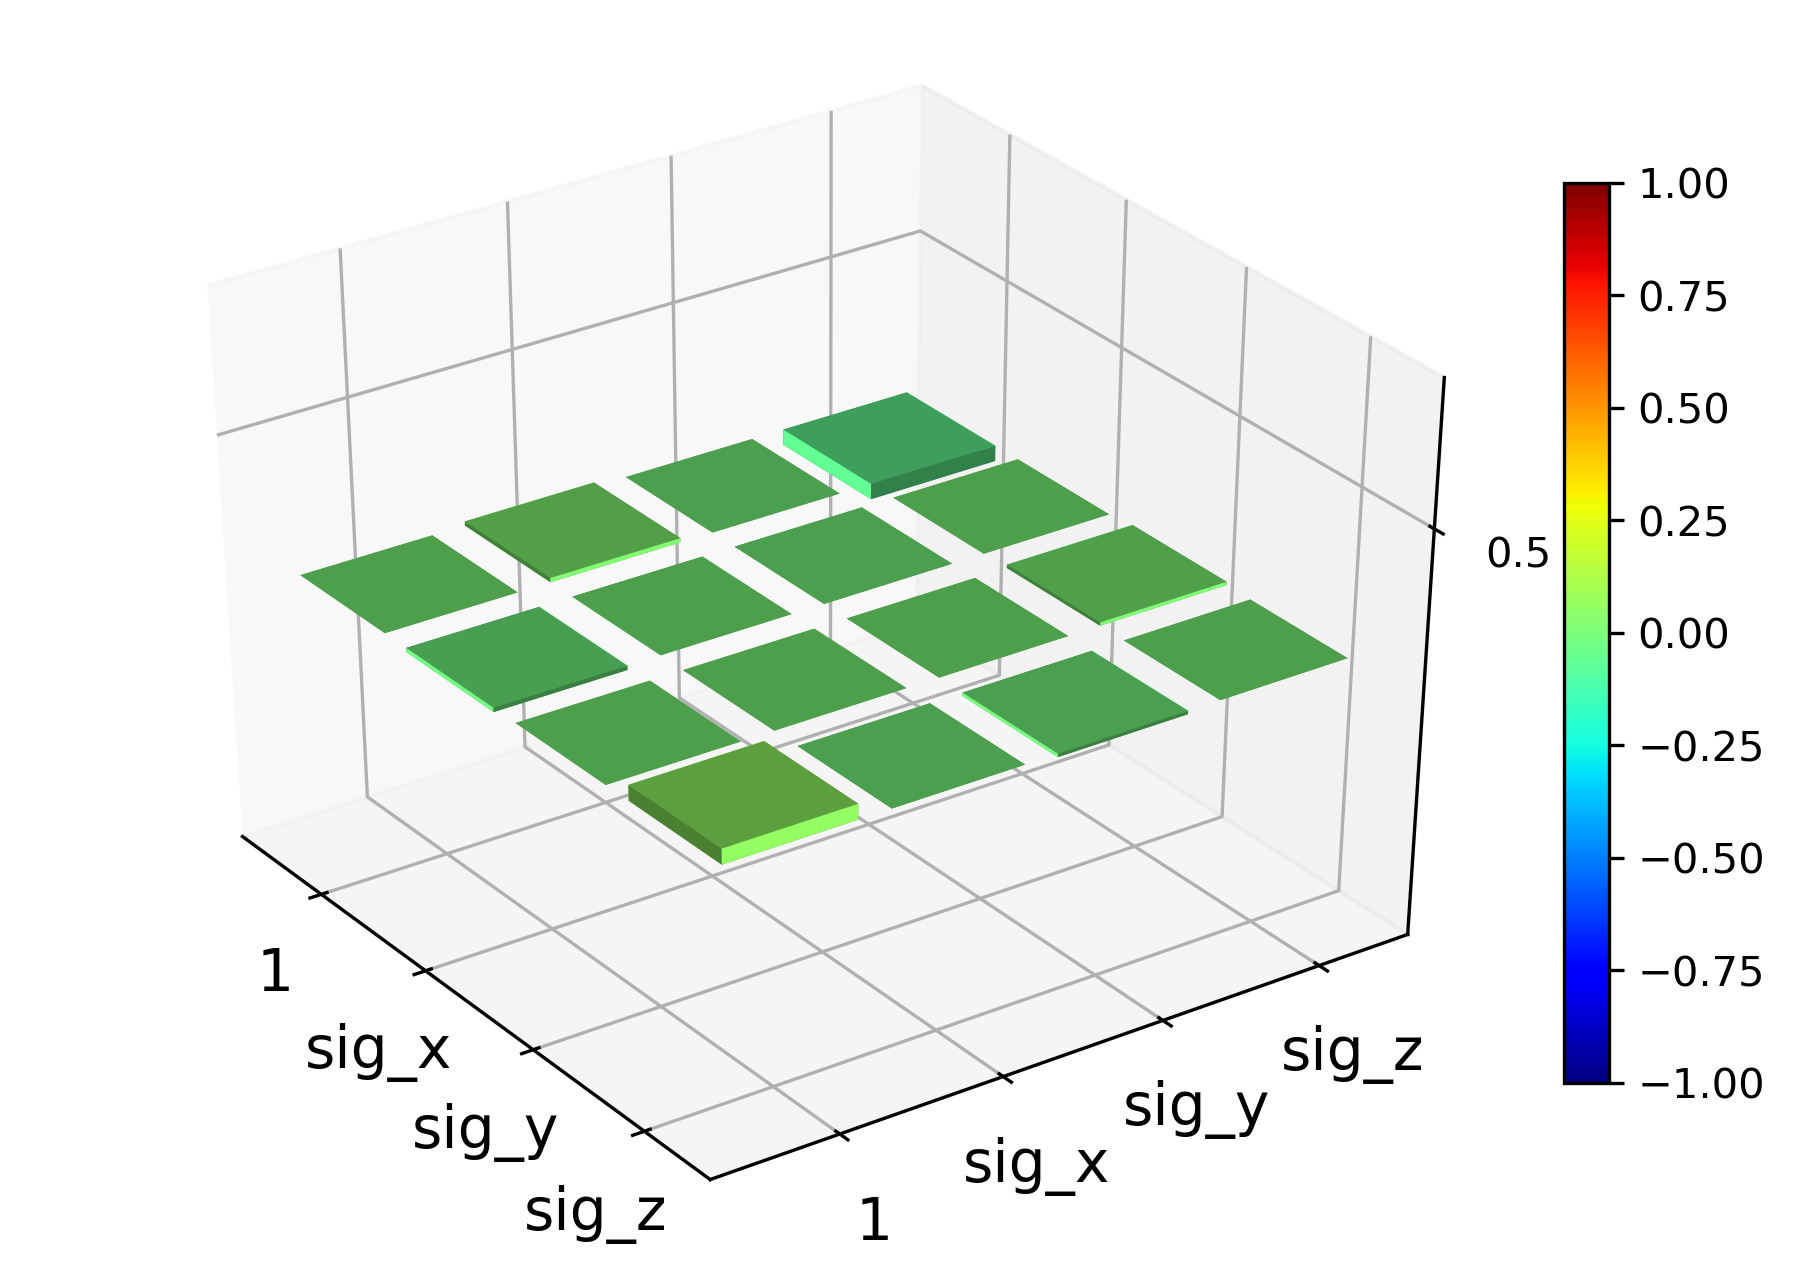

(array([[ 0.735+0.j   ,  0.   +0.016j,  0.017-0.j   , -0.   -0.059j],
        [ 0.   -0.016j,  0.   +0.j   ,  0.   -0.j   , -0.006+0.j   ],
        [ 0.017+0.j   ,  0.   +0.j   ,  0.001+0.j   ,  0.   +0.013j],
        [-0.   +0.059j, -0.006-0.j   ,  0.   -0.013j,  0.264+0.j   ]]),
 0.5071323543797818)

In [42]:
chi_tomo = sim_process_tomo(pulse, B, delta_f=-190e6)

qutip.matrix_histogram(np.real(chi_tomo), limits=[-1,1],
                       xlabels=["1", "sig_x", "sig_y", "sig_z"], 
                       ylabels=["1", "sig_x", "sig_y", "sig_z"])
plt.show()
qutip.matrix_histogram(np.imag(chi_tomo), limits=[-1,1],
                       xlabels=["1", "sig_x", "sig_y", "sig_z"], 
                       ylabels=["1", "sig_x", "sig_y", "sig_z"])
plt.show()

fom = np.real(1 - fidelity_chi_pi_x(chi_tomo))
chi_tomo, fom

Process tomography elements vs freq


In [486]:

deltas = np.linspace(-200e6,0, 80)
res = []

for delta in deltas:
    chi_tomo = sim_process_tomo(pulse, B, delta_f=delta)
    sigz_comp = chi_tomo[3][3]
    res.append(sigz_comp)
    

C:\ProgramData\Anaconda3\envs\qudi\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


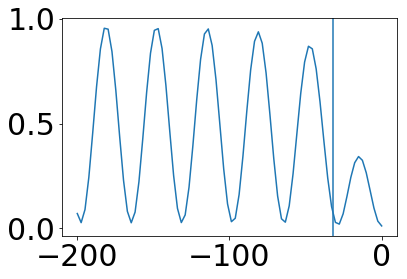

In [487]:
plt.plot(deltas/1e6, res)
plt.axvline(-1e-6/pulse.get_timegrid(unit='s')[-1])
plt.show()

## Frequency Detuning

In [31]:
f_block = np.asarray([f_res*1e-6 - 96, 3018.4, 2935.6])
f_block


array([2729. , 3018.4, 2935.6])

In [221]:

#B = 86.07
f_res = 2825e6
B = abs(f_res*1e-6-simp.D)/simp.gamma_nv
df = 150#120#120 # MHz

#f_block = (f_res - 93e6)*1e-6 # MHz
f_block = np.asarray([f_res*1e-6 - 95.6, 3018.4, 2935.6])
df_block = 10
fac_penalty = 100


symm_block = True
f_mw = simp.D-simp.gamma_nv * B

n_f = np.min([int(df/0.25), 500])
n_f= 150



sim = TimeDependentSimulation()

freq_array = np.linspace(simp.D - simp.gamma_nv * B - df, simp.D - simp.gamma_nv * B + df, n_f)

data_freq_detuning = sim.run_sim_fsweep(freq_array, pulse, B, simp)

penalty = calc_crosstalk_penalty(1e6*freq_array, data_freq_detuning, 1e6*f_mw, 1e6*f_block, 1e6*df_block,
                                 symm_block=symm_block, fac_penalty=fac_penalty)


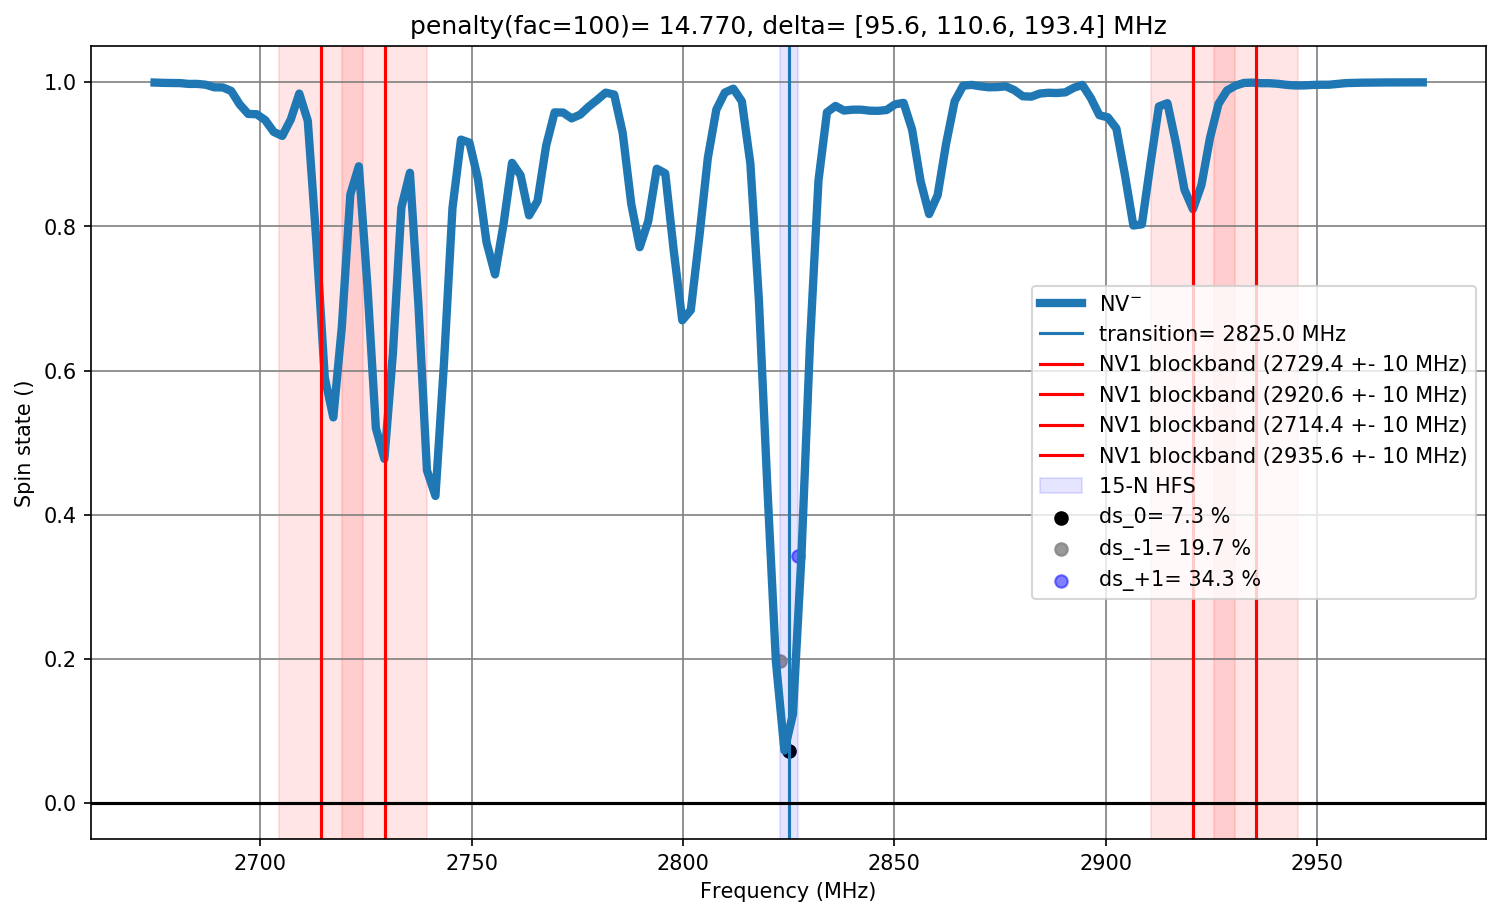

In [222]:
delta_hfs = 2.1 # MHz
f_mw = f_res*1e-6  # MHz

# value at the HFS values
vals = []
deltas = [0, -delta_hfs, delta_hfs]
for delta in deltas:
    idx = np.argmin(abs(freq_array-(f_mw+delta)))
    vals.append(data_freq_detuning[idx])


title_str = ""

# visualize the results
fig1, ax = plt.subplots(figsize=(12,7))
#mpl.rcParams['figure.dpi'] = 600

ax.plot(freq_array, data_freq_detuning, lw=4, label=r'NV${}^{-}~|m_s=0\rangle$')
#ax.plot(freq_array+2*(B-B_nv2)/2*simp.gamma_nv, data_freq_detuning, lw=4, label=r'NV${}^{-}~|m_s=0\rangle$')
#ax.plot(f_exp_mhz, y_exp, label="exp")
#ax.plot(f_exp_mhz_mirr, y_exp, label="mirrored(exp)")
#ax.set_xlim([2603,2653])

# vertical dots at values of HFS transitions
ax.scatter(f_mw+deltas[0], vals[0], color='black', label=f"ds_0= {1e2*vals[0]:.1f} %")
ax.scatter(f_mw+deltas[1], vals[1], color='grey', label=f"ds_-1= {1e2*vals[1]:.1f} %", alpha=0.8)
ax.scatter(f_mw+deltas[2], vals[2], color='blue', label=f"ds_+1= {1e2*vals[2]:.1f} %", alpha=0.5)

ax.axvline(f_mw, label=f"transition= {f_mw:.1f} MHz")
ax.axvspan(f_mw-2.1, f_mw+2.1, alpha=0.1, color='blue', label='15-N HFS')


# blockbands
f_lims = get_f_limits(1e6*f_mw, 1e6*f_block, 1e6*df_block, symm_block=symm_block)
for f_min, f_max in f_lims:
    f_center = (f_max + f_min) / 2
    if 1e-6*f_center > freq_array[0] and 1e-6*f_center < freq_array[-1]: 
        ax.axvline(1e-6*f_center, label=f"NV1 blockband ({1e-6*f_center:.1f} +- {df_block} MHz)", color='red')
        ax.axvspan(1e-6*f_min, 1e-6*f_max, alpha=0.1, color='red')

title_str += f"penalty(fac={fac_penalty})= {penalty:.3f}, delta= {sorted(np.around(abs(f_mw-f_block),decimals=2))} MHz"
        
# grid
ax.axhline(0, color='black')
#ax.axhline(1, color='black')
plt.grid(axis='x', color='0.5')
plt.grid(axis='y', color='0.5')




ax.set_xlabel(r'Frequency (MHz)')
ax.set_ylabel(r'Spin state ()')
plt.title(title_str)
ax.legend(loc='best', prop={'size': 10})
plt.show(fig1)

## Amplitude Error

In [219]:
B= 90 #gauss

sim = TimeDependentSimulation()

# scanned amplitude steps
amp_array = np.linspace(-0.15, 0.15, 50)
data_amp_detuning = sim.run_sim_ampsweep(amp_array, pulse, B, simp)



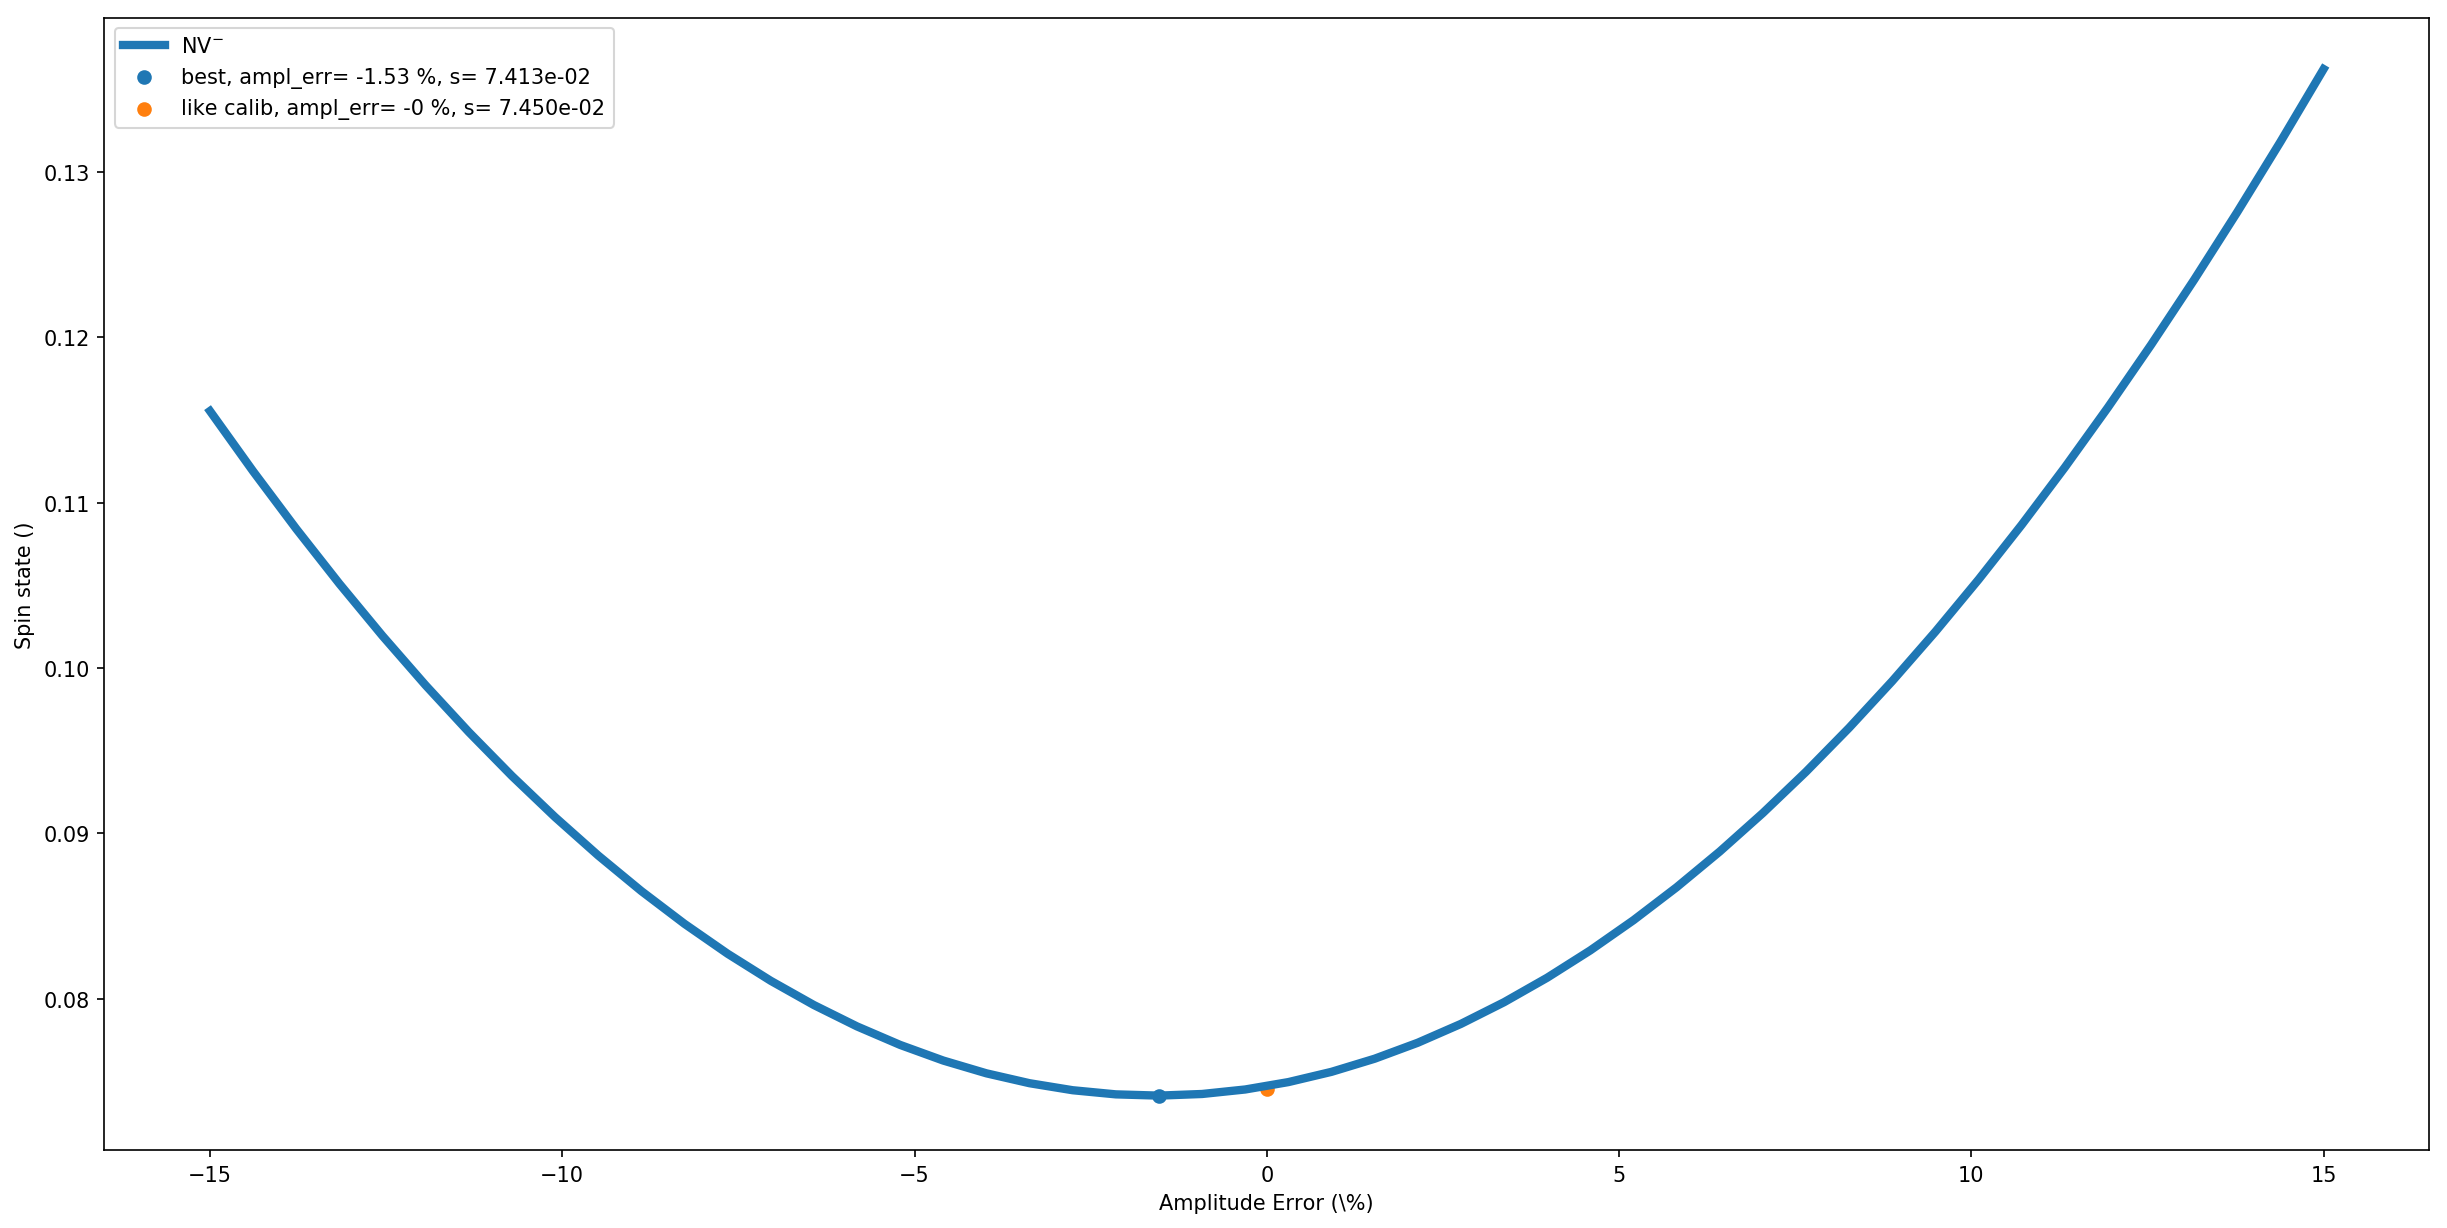

In [220]:
# visualize the results
fig2, ax = plt.subplots(figsize=(20,10))
ax.plot(amp_array*100, data_amp_detuning, lw=4, label=r'NV${}^{-}~|m_s=0\rangle$')
ax.set_xlabel(r'Amplitude Error (\%)')
ax.set_ylabel(r'Spin state ()')

# value at the minimum
vals_x, vals_y = [], []
idx = np.argmin(data_amp_detuning)
vals_x.append(100*amp_array[idx])
vals_y.append(data_amp_detuning[idx])

plt.scatter(vals_x, vals_y, label=f"best, ampl_err= {vals_x[0]:.2f} %, s= {vals_y[0]:.3e}")

vals_x, vals_y = [], []
idx = np.argmin(abs(amp_array))
vals_x.append(amp_array[idx])
vals_y.append(data_amp_detuning[idx])

plt.scatter(vals_x, vals_y, label=f"like calib, ampl_err= {vals_x[0]:.0f} %, s= {vals_y[0]:.3e}")



plt.legend()
plt.show(fig2) 

In [588]:
 np.argmin(data_amp_detuning)

49

## 2D Robustness

In [377]:

f_res = 2800e6

df = 5 # MHz
n_f= 30
da = 0.15
n_a = 30



B = abs(f_res*1e-6-simp.D)/simp.gamma_nv
f_mw = simp.D-simp.gamma_nv * B

sim = TimeDependentSimulation()

amp_array = np.linspace(-da, da, n_a)
freq_array = np.linspace(f_mw - df, f_mw + df, n_f)
res_array = np.zeros((len(amp_array), len(freq_array)))

for i, ampl in enumerate(amp_array):

    data_freq_detuning = sim.run_sim_fsweep(freq_array, pulse, B, simp, ampl_err=ampl)
    res_array[i,:] = data_freq_detuning


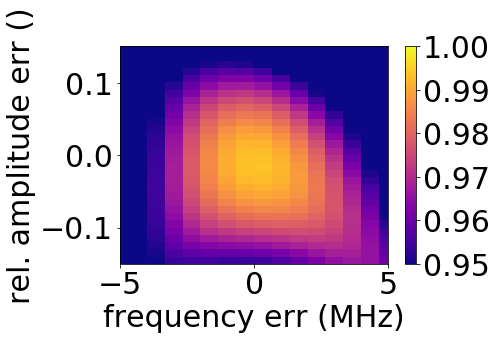

In [382]:
plt.imshow(1-res_array,  origin='lower', extent=[freq_array[0]-f_mw, freq_array[-1]-f_mw, amp_array[0], amp_array[-1]],
               aspect='auto', cmap='plasma', vmin=0.95, vmax=1)
plt.xlim([-5,5])

plt.xlabel('frequency err (MHz)')
plt.ylabel('rel. amplitude err ()')
plt.colorbar()
plt.show()

In [73]:
df = 5 # MHz
n_f= 25
freq_array = np.linspace(f_mw - df, f_mw + df, n_f)
freq_array

array([2595.   , 2595.417, 2595.833, 2596.25 , 2596.667, 2597.083,
       2597.5  , 2597.917, 2598.333, 2598.75 , 2599.167, 2599.583,
       2600.   , 2600.417, 2600.833, 2601.25 , 2601.667, 2602.083,
       2602.5  , 2602.917, 2603.333, 2603.75 , 2604.167, 2604.583,
       2605.   ])

In [72]:
df

125

In [126]:
pulse